In [4]:
import numpy as np # linear algebras 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy import misc
import imageio
import matplotlib.pyplot as plt
from os import listdir
import random

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,accuracy_score
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#creating figures
import matplotlib.pyplot as plt
import seaborn as sns

#resizing
import cv2

#prevent warnings messages
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
tf.logging.set_verbosity(tf.logging.ERROR)

In [5]:
# resize image and turn pixel values between 0 and 1
IMG_SHAPE = 50

# cell labels are 1 if infected, 0 if uninfected.
cell_labels = []

# cells 
cell_images = []

#first six infected and unfected cells for visualization only
infected_cells = []
uninfected_cells = []

#listdir("../input/cell_images/cell_images/")
base_path = "E:/THESIS MALARIA/cell_images/"

#get infected cells
infected_path = base_path +'Parasitized/'
for file in listdir(infected_path):
    if file.endswith('.png'):
        file_path = infected_path + file
        image = imageio.imread(file_path)
        image = cv2.resize(image,(IMG_SHAPE,IMG_SHAPE)).astype('float32')/255.0
        infected_cells.append(image)
        cell_images.append(image)
        cell_labels.append(1)

            
#get uninfected cells
uninfected_path = base_path +'Uninfected/'
for file in listdir(uninfected_path):
    if file.endswith('.png'):
        file_path = uninfected_path + file
        image = imageio.imread(file_path) 
        image = cv2.resize(image,(IMG_SHAPE,IMG_SHAPE)).astype('float32')/255.0   
        uninfected_cells.append(image)
        cell_images.append(image)
        cell_labels.append(0)

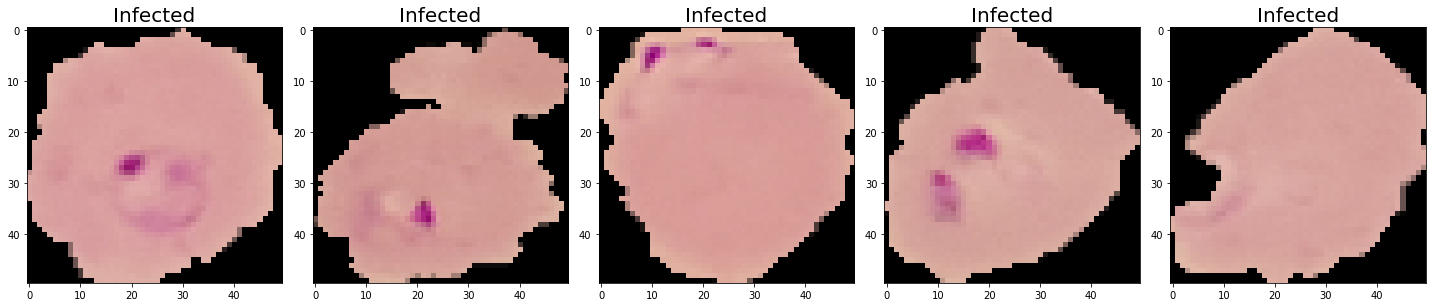

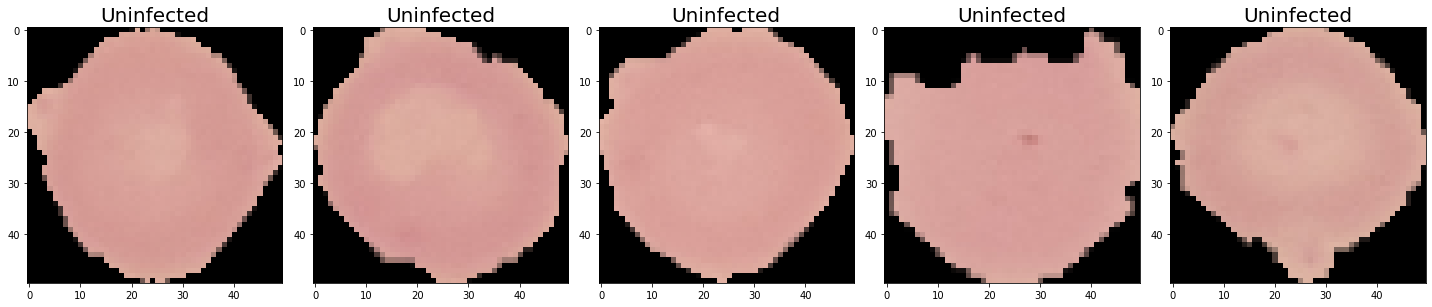

In [8]:
def ShowFirstSix(images_arr,title):

    fig, axes = plt.subplots(1, 5, figsize=(20,20))

    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.set_title(title,fontsize=20)
    plt.tight_layout()
    plt.show()
ShowFirstSix(infected_cells,'Infected')
ShowFirstSix(uninfected_cells,'Uninfected')

In [9]:
def reorder(old_list,order):
    new_list = []
    for i in order:
        new_list.append(old_list[i])
    return new_list

np.random.seed(seed=42)
indices = np.arange(len(cell_labels))
np.random.shuffle(indices)
indices = indices.tolist()
cell_labels = reorder(cell_labels,indices)
cell_images = reorder(cell_images,indices)

#change to arrays
image_array = np.array(cell_images)
label_array = np.array(cell_labels)

In [10]:
# 30% of the data goes to the training data set
X_train, X_test, y_train, y_test = train_test_split(image_array, label_array, train_size=0.70, random_state=100)

# 30% additional data goes to the validation data set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=len(y_test), random_state=100)

print("size of training data set {}".format((X_train.shape[0])))
print("size of validating data set {}".format(X_val.shape[0]))
print("size of testing data set {}".format(X_test.shape[0]))

size of training data set 11022
size of validating data set 8268
size of testing data set 8268


In [13]:
#seeding random seed so I can get consist results
tf.set_random_seed(10)

model =  Sequential([
    
    #convolutional layers
    Conv2D(32, (3,3), activation='relu', input_shape=(50,50, 3),padding='same'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu',padding='same'),
    MaxPooling2D(2,2),  
    Conv2D(128, (3,3), activation='relu',padding='same'),
    MaxPooling2D(2,2),
    
    # dense layer
    Flatten(),
    Dropout(0.50),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])


# Compile the model
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.binary_accuracy])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
__________

In [15]:
epochs = 20
batch_size =  600
history = model.fit(X_train,y_train,
    steps_per_epoch=int(np.ceil(len(y_train)/ float(batch_size))),
    epochs=epochs,
    validation_data=(X_val,y_val),
    validation_steps=int(np.ceil(len(y_val) / float(batch_size)))
)

Epoch 1/20
19/19 [==============================] - 767s 40s/step - loss: 0.6709 - binary_accuracy: 0.5800 - val_loss: 0.6328 - val_binary_accuracy: 0.6468
Epoch 2/20
19/19 [==============================] - 813s 43s/step - loss: 0.6148 - binary_accuracy: 0.6647 - val_loss: 0.5804 - val_binary_accuracy: 0.6925
Epoch 3/20
10/19 [==============>...............] - ETA: 11:35 - loss: 0.5693 - binary_accuracy: 0.7082

KeyboardInterrupt: 

[]

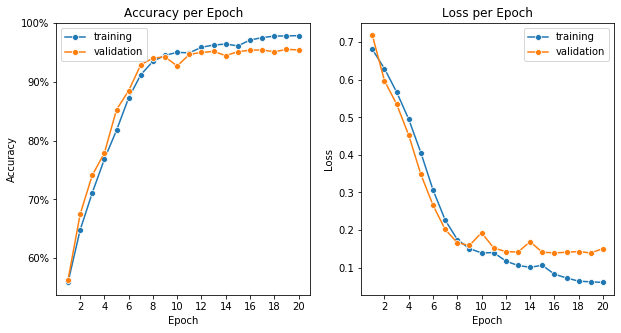

In [8]:
#Plot accuracy and loss per epoch

#accuracy
train_accuracy = history.history['binary_accuracy']
validation_accuracy = history.history['val_binary_accuracy']

#loss 
train_loss = history.history['loss']
validation_loss = history.history['val_loss']

epoch_range = range(1,len(train_accuracy)+1)

fig, ax = plt.subplots(1, 2, figsize=(10,5))

#accuracy
ax[0].set_title('Accuracy per Epoch')
sns.lineplot(x=epoch_range,y=train_accuracy,marker='o',ax=ax[0])
sns.lineplot(x=epoch_range,y=validation_accuracy,marker='o',ax=ax[0])
ax[0].legend(['training','validation'])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_xticks([2,4,6,8,10,12,14,16,18,20])
ax[0].set_yticks([.6,.7,.8,.9,1.0])
ax[0].set_yticklabels(['60%','70%','80%','90%','100%'])
#loss
ax[1].set_title('Loss per Epoch')
sns.lineplot(x=epoch_range,y=train_loss,marker='o',ax=ax[1])
sns.lineplot(x=epoch_range,y=validation_loss,marker='o',ax=ax[1])
ax[1].legend(['training','validation'])
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_xticks([2,4,6,8,10,12,14,16,18,20])
plt.plot()

8268/8268 [==============================] - 6s 681us/sample - loss: 0.1596 - binary_accuracy: 0.9496


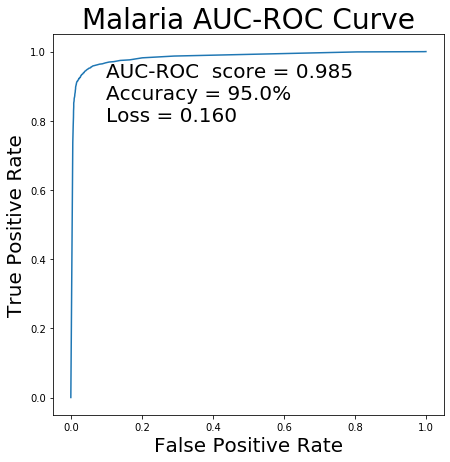

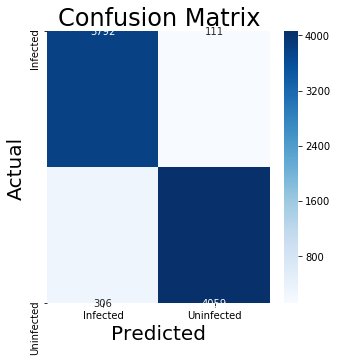

In [10]:
def GetFalseTruePositiveRate(y_true,y_prob,threshold):

    y_predict = np.fromiter([1 if x > threshold else 0 for x in y_prob ],int)
    n_positives = y_true.sum()
    n_negatives = y_true.shape[0] - n_positives
    
    # get n true positives
    n_true_pos = 0
    n_false_pos = 0
    for pred_value,true_value in zip(y_predict,y_true):
        # true positive
        if true_value == 1 and pred_value == 1:
            n_true_pos += 1
        # false positive
        elif true_value == 0 and pred_value == 1:
            n_false_pos += 1
    true_pos_rate = n_true_pos/n_positives
    false_pos_rate = n_false_pos/n_negatives
    return false_pos_rate,true_pos_rate

def MakeConfusionMatrix(y_true,y_prob,threshold):
    confusion_matrix = np.array([[0,0],[0,0]])
    for pred_value,true_value in zip(y_prob,y_true):
        if true_value == 1:
            #true positive
            if pred_value > threshold:
                confusion_matrix[0,0] += 1
            #false negative
            else:
                confusion_matrix[1,0] += 1
        else:
            #false positive
            if pred_value > threshold: 
                 confusion_matrix[0,1] += 1
            #true negative
            else:
                confusion_matrix[1,1] += 1       
    fig = plt.figure(figsize=(5,5))
    ax =  fig.gca()
    sns.heatmap(confusion_matrix,ax=ax,cmap='reds',annot=True,fmt='g',
               xticklabels = ['Infected','Uninfected'],
               yticklabels=['Infected','Uninfected'])
    ax.set_ylabel('Actual',fontsize=20)
    ax.set_xlabel('Predicted',fontsize=20)
    plt.title('Confusion Matrix',fontsize=24)
    plt.show()

y_predict = model.predict(X_test)
thresholds = np.arange(0.01,1.01,0.01)
thresholds = np.append(np.array([0,0.00001,0.0001,0.001]),thresholds)
roc_auc = np.array([GetFalseTruePositiveRate(y_test,y_predict,n) for n in thresholds ]) 
roc_auc = np.sort(roc_auc,axis=0)
roc_auc_value = roc_auc_score(y_test,y_predict)
loss,accuracy = model.evaluate(X_test,y_test)
accuracy = accuracy
loss = loss
text = 'AUC-ROC  score = {:.3f}'.format(roc_auc_value)
text += '\nAccuracy = {:.1f}%'.format(accuracy*100)
text += '\nLoss = {:.3f}'.format(loss)

fig = plt.figure(figsize=(7,7))
ax =  fig.gca()
ax.set_title('Malaria AUC-ROC Curve',fontsize=28)
ax.set_ylabel('True Positive Rate',fontsize=20)
ax.set_xlabel('False Positive Rate',fontsize=20)
ax.plot(roc_auc[:,0],roc_auc[:,1])
ax.text(s=text,x=0.1, y=0.8,fontsize=20)
plt.show()

MakeConfusionMatrix(y_test,y_predict,0.5)